# Text classification 

### Quick summaries 

- DV = outcome = response = target = table in machine learning parlance.
- Continuous response variable = regression (don't confuse with OLS)
- Categorical response variable = classification 
 
### Key ideas
- It is **supervised learning** because we know something (**the target sample**) about the response variable. 
- It is **classification** because the target sample (seen data) and the target (unseen data) are **categorical variables**. 
- If the goal (labeling the output) is to identify **yes or no**, then it is **binary classification**.
- If the goal is to identify **discrete values**, then it is multiclass or **multinomial classification**. 

### Workflow
1. Prepapre a hand-labeled sample from the target data. 
2. Preprocess the sample and split the sample into the train and test set.
3. Extract features.
4. Train a (predictive) model. 
5. Test the model. 
6. Use the model to label the unseen data (we don't do this in this tutorial).

What I'm presenting here is a simpilfied version of the code I used for my disseratation chapter. Also, I adapted some contents from [Applied Text Analysis with Python](https://proquest-safaribooksonline-com.libproxy.berkeley.edu/book/programming/python/9781491963036/5dot-classification-for-text-analysis/idm140629385710352_html) by Bengfort (2018). The book is not thoeretically deep, but provides good technical details.


## Setup

### Load libraries

Not all of these libraries are needed to do this tutorial.

In [1]:
%matplotlib inline
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np # for large data 
import pandas as pd # for data manipulation and analysis
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns
import gensim, nltk, re, string, xgboost, textblob, spacy

# NLTK

from nltk import word_tokenize, sent_tokenize # for tokenization
from nltk.corpus import stopwords # for stop words

stop = stopwords.words('english')

from nltk.stem import WordNetLemmatizer # lemmatizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk import tokenize
from collections import Counter

import contractions
import inflect
from bs4 import BeautifulSoup

import unicodedata

from pattern.en import tag
from nltk.corpus import wordnet as wn

# Learning algorithms

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble 
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
sns.set()

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec # for word2vec

from keras.preprocessing import text, sequence 
from keras import layers, models, optimizers

Using TensorFlow backend.


### Load data

I have a collection of newspaper articles labeled by my undergraduate RAs.

In [2]:

# Load data using pandas library 
aa_newspapers = pd.read_csv("/home/jae/PS239T/14_supervised-machine-learning/data/african_american_newspapers.csv")


In [3]:

# Basic information about the sample 
aa_newspapers.info()

# Look at the first 5 rows 
aa_newspapers.head()

# I don't like Unnamed: 0 column, so let's drop it. axis = 1 argument specifies that I'm dropping a column.
aa_newspapers = aa_newspapers.drop('Unnamed: 0', axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 8 columns):
Unnamed: 0         1008 non-null int64
author             242 non-null object
date               1008 non-null object
source             1008 non-null object
text               1008 non-null object
year               1008 non-null int64
linked_progress    1008 non-null int64
linked_hurt        1008 non-null int64
dtypes: int64(4), object(4)
memory usage: 63.1+ KB


## Preprocessing

### Remove special characters, punctuations, numbers, and whitespace

Obviously, if you want to, you can process the data further by removing stopwods, applying stemming (converting words to root forms), tagging parts of speech (e.g., nouns, verbs, adverbs), and so on. For the more advanced techniques, you need to use `nltk` library. Note that preprocessing data makes the analysis more efficient, but it does not mean the the analysis is going to be more valid. 

In [4]:
# Create a list of things you want to replace with "" (basically, deleting them)

aa_newspapers['text'] = aa_newspapers['text'].str.replace('\n','', regex = True).str.replace('[^\w\s]','', regex = True)
aa_newspapers['text'] = aa_newspapers['text'].str.replace('\d+', '', regex = True) # remove numbers
aa_newspapers['text'] = aa_newspapers['text'].str.strip() # remove whitespace

# Check 
aa_newspapers['text'][2]

'KTVUs televoters were back to being pretty uptight this weekSan Franciscos Mayor Alioto should not apologize to the Black Panthers for his remarks about the Sunday night bombings in the opinion of  percentTeachers should not strike if violence is not curbed in high schools   percent to Fiftythree percent did not agree with President Johnsons announcement on Vietnam and  percent do not think the bombing halt will result in peace in Vietnam  As a matter of fact you might say Dont give up the ship was the byword of viewers polled by Channel  in its weekly question and answer periodHowever the San FranciscoOakland TV station stressed the continuing nonscientific not necessarily representative of community opinion nature of its poll'

### Lower case

In [5]:
# Lower case
aa_newspapers['text'] = aa_newspapers['text'].str.lower()

In [6]:
# Check
aa_newspapers['text'][2]

'ktvus televoters were back to being pretty uptight this weeksan franciscos mayor alioto should not apologize to the black panthers for his remarks about the sunday night bombings in the opinion of  percentteachers should not strike if violence is not curbed in high schools   percent to fiftythree percent did not agree with president johnsons announcement on vietnam and  percent do not think the bombing halt will result in peace in vietnam  as a matter of fact you might say dont give up the ship was the byword of viewers polled by channel  in its weekly question and answer periodhowever the san franciscooakland tv station stressed the continuing nonscientific not necessarily representative of community opinion nature of its poll'

## Model building

### Feature selection (feature engineering)

We need to turn text into numerical vectors called features. This process is called [text vecotriazation](https://monkeylearn.com/blog/beginners-guide-text-vectorization/). There are various ways to do so, ranging from simple bag of words to TF-IDF to word embeddings (e.g., word2vec). In this case, we try bag of words.


In [7]:
# Extract features 

In [8]:

## Create a vectorizer 
vectorizer = CountVectorizer(
    min_df = 1,
    ngram_range = (1,2),
    max_features = 5000,
    binary = True)


In [9]:

## Create a function that builds a model 
def dtm_train(data, text, column, date, k):
    # Bag of words model
    
    features = vectorizer.fit_transform(data[text])
    
    response = data[column].values 

    # split into train/test datasets 

    X_train, X_test, y_train, y_test = train_test_split(features, response,
                                                        # Randomly split the sample into the training and test sets 
                                                        # 80% of the sample data goes to the training set, 
                                                        # and the rest goes to the test set 
                                                        test_size = k,
                                                        # Setting random state is important for reproducibility 
                                                        random_state = 1234,
                                                        # I stratified on the publication date
                                                        stratify = data[date])

    return(X_train, y_train, X_test, y_test)

In [10]:

# Linked progress
aa_dtm_lp = dtm_train(aa_newspapers, 'text', 'linked_progress', 'year', 0.2)
aa_X_train_lp = aa_dtm_lp[0]
aa_y_train_lp = aa_dtm_lp[1]
aa_X_test_lp = aa_dtm_lp[2]
aa_y_test_lp = aa_dtm_lp[3]

# Linked hurt 
aa_dtm_lh = dtm_train(aa_newspapers, 'text', 'linked_hurt', 'year', 0.2)
aa_X_train_lh = aa_dtm_lh[0]
aa_y_train_lh = aa_dtm_lh[1]
aa_X_test_lh = aa_dtm_lh[2]
aa_y_test_lh = aa_dtm_lh[3]

In [11]:
# Type of the output 

type(aa_X_train_lp)

scipy.sparse.csr.csr_matrix

### Training a model

In the end, we want to apply the model to the unseen data. You might face one of the two problems while going down the road. 

1. Overfitting: high variance, low bias -- **bad** at making the same predictions on the unseen data, but **good** at making correct predictions (likely happens to a too complicated model)
2. Underfitting: low variance, high bias -- **good** at making the same predictions on the unseen data, but **bad** at making correct predictions (likely happens to a too simple model)

In short, there is a trade-off between variance (reliability) and bias (validity). You want to find a model that balances between them.

![Example](https://cdn-images-1.medium.com/max/1600/1*tBErXYVvTw2jSUYK7thU2A.png)


We use confusion matrix to measure the performance of a model. A confusion matrix is in simple terms "a table that outlines different predictions and test results and contrasts them with real-world values" (see [this blog post](https://whatis.techtarget.com/definition/confusion-matrix) for more information). 

The diagonal elements represent the number of points for which the predicted label is equal to the true value. Off-diagonal elements are those that are misclassified by the model. 

1. Accuracy rate: TP + TN (the ability of the model to label positive a sample that is positive and negative a sample that is negative)
2. Precision rate: TP + FP (the ability of the model to not to label as positive a sample that is negative)

![Confusion matrix](https://cdn-images-1.medium.com/max/1000/1*Wk2VkUg3h1IbeR1bPF42NA.jpeg)

I used plot_confusion_matrix function from [scikit-learn library website](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) to visualize the matrix with a very small modification. Since we don't have many labels, I changed the function so that it doesn't need classes argument. 

In [12]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    classes = unique_labels(y_true, y_pred)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

We're building two models: [logistic regression](http://www-stat.wharton.upenn.edu/~stine/mich/DM_05.pdf) and [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). 

**Fun fact**
- Naive Bayes assumes that each feature (word) is independent. But still very powerful for predictions, and widely used in spam filtering.


In [13]:
# Logistic regression
def fit_logistic_regression(X_train, y_train):
    model = LogisticRegression(max_iter = 4000)
    model.fit(X_train, y_train)
    return model

# Naive Bayes
def fit_bayes(X_train, y_train):
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model

def test_model(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, normalize = False, # I prefer to not normalize 
                         title = "Normalized Confusion Matrix")
    print("Accuracy rate is {}".format(round(accuracy_score(y_test, y_pred), 2)))
    return(y_pred)

In [14]:

## Linked progress
aa_lp = fit_logistic_regression(aa_X_train_lp, aa_y_train_lp)
aa_lp_bayes = fit_bayes(aa_X_train_lp, aa_y_train_lp)

## Linked hurt 
aa_lh = fit_logistic_regression(aa_X_train_lh, aa_y_train_lh)
aa_lh_bayes = fit_bayes(aa_X_train_lh, aa_y_train_lh)

### Model testing 

Also, try to run the test analysis with/without normalizing the confusion matrix. In your opinion, which one is more informative? 

**Tips** It depends on the size of each cell in the matrix.

If you're testing more than 2 models, then it's better to use [pipeline](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976).

Linked progress: Logistic regression
Confusion matrix, without normalization
[[145  15]
 [ 25  17]]
Accuracy rate is 0.8
Linked progress: Naive Bayes
Confusion matrix, without normalization
[[114  46]
 [  9  33]]
Accuracy rate is 0.73
Linked hurt: Logistic regression
Confusion matrix, without normalization
[[156   6]
 [ 23  17]]
Accuracy rate is 0.86
Linked hurt: Naive Bayes
Confusion matrix, without normalization
[[137  25]
 [  8  32]]
Accuracy rate is 0.84


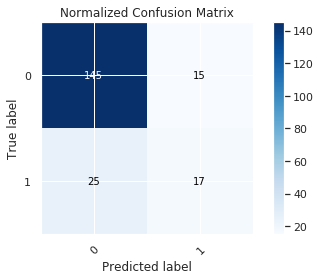

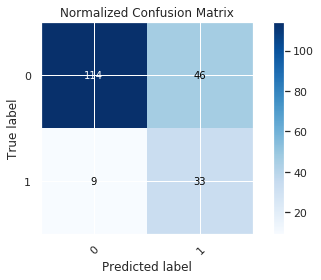

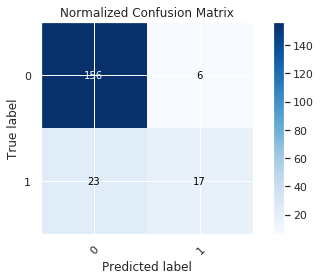

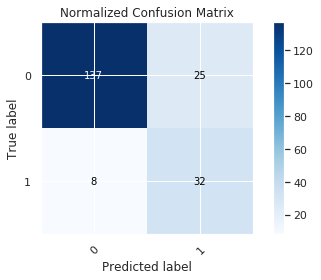

In [15]:

## Linked progress
print("Linked progress: Logistic regression")
aa_lp_lr_test = test_model(aa_lp, aa_X_train_lp, aa_y_train_lp, aa_X_test_lp, aa_y_test_lp)

print("Linked progress: Naive Bayes")
aa_lp_bayes_test = test_model(aa_lp_bayes, aa_X_train_lp, aa_y_train_lp, aa_X_test_lp, aa_y_test_lp)

## Linked hurt
print("Linked hurt: Logistic regression")
aa_lh_lr_test = test_model(aa_lh, aa_X_train_lh, aa_y_train_lh, aa_X_test_lh, aa_y_test_lh)

print("Linked hurt: Naive Bayes")
aa_lh_lr_test = test_model(aa_lh_bayes, aa_X_train_lh, aa_y_train_lh, aa_X_test_lh, aa_y_test_lh)

## Cross-validation

The simple train-test method is easy to implement and interpret. But the problem is it can be biased (different training sets can give different results) and is inefficient. A quick fix to this problem is using cross-validation methods. In this tutorial, we use k-fold cross validation approach. We split out training set into k-folds, train on k-1 one of those for test, calculate some metrics (e.g., accuracy), iterate this process, and then calculate the average of a metric of our interest. 

![Cross validation](https://cdn-images-1.medium.com/max/1000/1*4G__SV580CxFj78o9yUXuQ.png)

In [16]:
# Build a model 

features = vectorizer.fit_transform(aa_newspapers['text'])
    
response = aa_newspapers['linked_progress'].values 

model = fit_logistic_regression(features, response)

In [17]:
# Train the model using cross-validation

for i in range(2 , 10):
    print("Accuracy score of logistic regression on linked progreess is: "+ 
        str(cross_val_score(model, features, response, cv = i, scoring = "accuracy").mean()))

Accuracy score of logistic regression on linked progreess is: 0.7866996043540736
Accuracy score of logistic regression on linked progreess is: 0.762907194633024
Accuracy score of logistic regression on linked progreess is: 0.7807836506411769
Accuracy score of logistic regression on linked progreess is: 0.7708512745252909
Accuracy score of logistic regression on linked progreess is: 0.7718938707538431
Accuracy score of logistic regression on linked progreess is: 0.768938963335515
Accuracy score of logistic regression on linked progreess is: 0.7718852643419573
Accuracy score of logistic regression on linked progreess is: 0.7718531584682027
